## This notebook follows the notebook Streams.ipynb.

Read this notebook only after reading Streams.ipynb.

# Examples of Stream Applications.

This notebook shows you how to develop applications on streams. The notebook defines problems that often arise in stream applications and develops Classes that solve the problems. We first review key concepts about streams.

# Review of key concepts about streams

Associated with a stream is a set of subscribers. A subscriber to a stream **s** is a function which is called when **s** is modified. A function **f** subscribes to a stream **s** by calling **s.subscribe(f)**. 

The diagram illustrates **s.start[f]**. In the diagram, **s.offset = N** and **s.start[f] = j**. 
Function **f** only reads items of stream **s** after **s[N + j]**, and equivalently function **f** only reads items of list **s.recent** after item **j**.

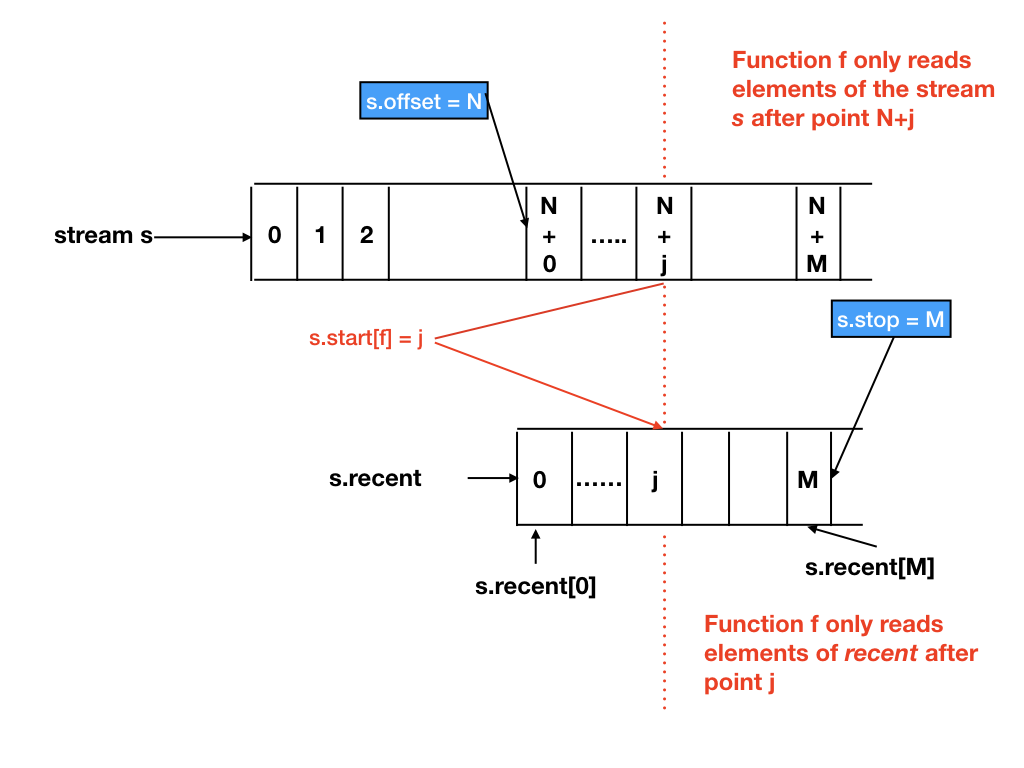

The following example illustrates **s.start[g]** for a function **g** and a stream **s**. In this example **s.offset=0** throughout the example; so, the stream **s** and the list **s.recent** are identical.



In [1]:
import sys
sys.path.append("../")

from stream import Stream, run

s = Stream(name='s')

def g():
    # s.stop = 0 throughout this example.
    print ('s.stop = ', s.stop)
    # s.recent[: s.stop] contains the items in stream s.
    print ('s.recent[: s.stop] = ', s.recent[: s.stop])
    print ('s.start[g] = ', s.start[g])
    print ('s.recent[s.start[g]: s.stop] = ', s.recent[s.start[g]: s.stop])
    print ()

# Function g subscribes to stream s
s.subscribe(g)
# s.start[g] = 0, s.stop =0, 

# Make s = ['A', 'B']
s.extend(['A', 'B'])
run()
# g is called when s is extended
# s.start[g] = 0, s.stop = 2 because 2 items have been added to stream s.

# Make s = ['A', 'B', 'C', 'D', 'E']
s.extend(['C', 'D', 'E'])
# Example showing a change to s.start[g]
s.start[g] = 2
run()
# s.start[g] = 2, s.stop = 5
    
# Make s = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
s.extend(['F', 'G', 'H', 'I'])
# Example showing a change to s.start[g]
s.start[g] = 5
run()
# s.start[g] = 2, s.stop = 5

s.stop =  2
s.recent[: s.stop] =  ['A', 'B']
s.start[g] =  0
s.recent[s.start[g]: s.stop] =  ['A', 'B']

s.stop =  5
s.recent[: s.stop] =  ['A', 'B', 'C', 'D', 'E']
s.start[g] =  2
s.recent[s.start[g]: s.stop] =  ['C', 'D', 'E']

s.stop =  9
s.recent[: s.stop] =  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
s.start[g] =  5
s.recent[s.start[g]: s.stop] =  ['F', 'G', 'H', 'I']



# Examples: Classes for Stream Operations

## single_item


#### An object of this class specified by a single input stream and  a function f with keyword arguments *kwargs*, where the function is executed on *each item*  of the input stream. The function is called when the input stream is extended.

### Solution
An object of the **single_item** class (below) has a method **callback** and a stream parameter **in_stream**. When the object is instantiated, **callback** subscribes to be called when **in_stream** is extended.

Let **s** be **in_stream**, and **f** be **callback** for short. **callback** operates on the following slice of the input stream: 
<code>
    s[s.offset + s.start[f] : s.offset + s.stop]
</code>

This slice is the same as:

<code>
    s.recent[s.start[f] : s.stop]
</code>

The callback applies **func** to the items in the slice.

<code>
    def callback(self):
        for v in self.in_stream.recent[self.in_stream.start[self.callback] : self.in_stream.stop]:
            self.func(v, **self.kwargs)
</code>

It then makes its new start index the same as the stop index to indicate that it will now continue reading items in the stream from the current stop index onwards.

<code>
        self.in_stream.start[self.callback] = self.in_stream.stop
</code>

In [2]:
class single_item(object):
    def __init__(self, in_stream, func, **kwargs):
        self.in_stream = in_stream
        self.func = func
        self.kwargs = kwargs
        self.in_stream.subscribe(self.callback)
    def callback(self):
        for v in self.in_stream.recent[self.in_stream.start[self.callback] : self.in_stream.stop]:
            self.func(v, **self.kwargs)
        self.in_stream.start[self.callback] = self.in_stream.stop

# Example illustrating single_item

This example has two instantiations of **single_item**. The first is passed function **f** and the second function **h**. 

<code>
    def f(v, out_stream): out_stream.append(2*v)
</code>
    
Function **f** has two parameters: an item **v** of the input stream and a keyword parameter, **out_stream**, which is the output stream.

<code>
    def h(v, out_stream, multiplier): out_stream.append(multiplier*v)
</code>

Function **h** has a three arguments, an item **v** of the input stream, and keyword arguments **out_stream** and **multiplier.** 

The next statement creates an agent to put values into stream **y**. 
<code>
    single_item(in_stream=x, out_stream=y, func=f)
</code>
    
This agent ensures that
<code>
    y[i] = 2*x[i]
</code>

The next statement creates an agent to put values into stream **z**. 

<code>
    single_item(in_stream=x, out_stream=z, func=h, multiplier=3)
</code>
    
This agent ensures that
<code>
    z[i] = multiplier*x[i]
</code>

Next we put values [0, 1, 2] into stream x and then run agents until they have processed all streams, and then print the recent values of streams **x, y, z**.
<code>
    x.extend([0, 1, 2])
    run()
</code>
    

In [3]:
#EXAMPLE ILLUSTRATING single_item

x, y, z = Stream(name='x'), Stream(name='y'), Stream(name='z')

# Examples of functions passed to map_stream objects below
# Function f has two parameters: an item v of the input stream
# and a keyword parameter, out_stream, which is the output stream.
def f(v, out_stream): 
    out_stream.append(2*v)
# This function has three parameters: the first is an item v of the
# input stream, the second is a keyword argument (see kwargs) out_stream,
# which is the output stream, and another keyword argument, multiplier.
def h(v, out_stream, multiplier): 
    out_stream.append(multiplier*v)

# Set up the agent with input stream x and output stream y.
single_item(in_stream=x, out_stream=y, func=f)
# Set up the agent with input stream x and output stream z.
single_item(in_stream=x, out_stream=z, func=h, multiplier=3)

# Put values into input stream x.
x.extend([0, 1, 2])
# Run agents until all streams have been processed.
run()
# Functions f and h are called when stream x is extended.
# Print the streams.
x.print_recent()
y.print_recent()
z.print_recent()
# y[i] = 2*x[i]), and z[i] = multiplier*x[i])

# Put values into input stream x.
x.extend([3, 4])
run()
# Functions f and h are called when stream x is extended.
# Print the output streams.
x.print_recent()
y.print_recent()
z.print_recent()

x  = [0, 1, 2]
y  = [0, 2, 4]
z  = [0, 3, 6]
x  = [0, 1, 2, 3, 4]
y  = [0, 2, 4, 6, 8]
z  = [0, 3, 6, 9, 12]


# Problem: Design a Class to join (merge) multiple streams

#### An object of this class is specified by a list, *in_streams*, of input streams, an output stream, *out_stream*, a function, *func* with keyword arguments, *kwargs*. Function *func* operates on a list consisting of the n-th item from each input stream. 


## Solution
In the code below, **slices[i]** is the slice of the **i**-th input stream that is visible to **callback**.
<code>
    slices = [in_stream.recent[in_stream.start[self.callback] : in_stream.stop]
                               for in_stream in self.in_streams]
</code>
    
The statement:
<code>
    zipped_slices = list(zip(*slices))
</code>
makes **zipped_slices** a list where the elements of the list consist of the **n**-th items of each of the input streams. For example if the slices of two input streams are [0, 1] and [10, 11] then **zipped_slices**  is [(0, 10), (1, 11)].

The code then executes **func** on each element of **zipped_slices** and then increments **start[callback]** by the length of **zipped_slices** to indicate that **callback** has finished operating on these **len(zipped_slices)**  items of each input stream .

<code>
        for v in zipped_slices: self.func(v, **self.kwargs)
        for in_stream in self.in_streams:
            in_stream.start[self.callback] += len(zipped_slices)
</code>

In [4]:
class join_synch(object):
    def __init__(self, in_streams, func, **kwargs):
        self.in_streams = in_streams
        self.func = func
        self.kwargs = kwargs
        for in_stream in self.in_streams: 
            in_stream.subscribe(self.callback)
    def callback(self):
        slices = [in_stream.recent[in_stream.start[self.callback] : in_stream.stop]
                  for in_stream in self.in_streams]
        zipped_slices = list(zip(*slices))
        print ('zipped_slices ', zipped_slices)
        for v in zipped_slices: self.func(v, **self.kwargs)
        for in_stream in self.in_streams:
            in_stream.start[self.callback] += len(zipped_slices)

# Example illustrating join_synch with Streams

This example has two input streams, **x, y** and an output stream **z**. The **join_synch** object sets

<code>
    z[n] = sum([x[n], y[n]]) * multiplier
</code>

The sequence of values of the parameter **v** in the call to function **f** is **[x[n], y[n]]** for **n = 0, 1, 2, ...**



In [5]:
# EXAMPLE ILLUSTRATING join_synch WITH Streams

def append_item_to_Stream(v, out_stream, multiplier):
    out_stream.append(sum(v) * multiplier)
    
x, y, z = Stream(name='x'), Stream(name='y'), Stream(name='z')
join_synch(
    in_streams=[x, y], out_stream=z, 
    func=append_item_to_Stream, multiplier=3)

x.extend([0, 1, 2])
y.extend([10, 11, 12, 13])
run()
x.print_recent()
y.print_recent()
z.print_recent()

x.extend([3, 4, 5, 6])
y.extend([10, 11, 12, 13, 14])
run()
x.print_recent()
y.print_recent()
z.print_recent()

zipped_slices  [(0, 10), (1, 11), (2, 12)]
x  = [0, 1, 2]
y  = [10, 11, 12, 13]
z  = [30, 36, 42]
zipped_slices  [(3, 13), (4, 10), (5, 11), (6, 12)]
x  = [0, 1, 2, 3, 4, 5, 6]
y  = [10, 11, 12, 13, 10, 11, 12, 13, 14]
z  = [30, 36, 42, 48, 42, 48, 54]


# Example illustrating join_synch with StreamArrays

Same as the previous example except that StreamArrays (rather than Streams) are joined.

The **func** that is called with **Stream** is **append_item_to_Stream** whereas **func** that is called with **StreamArray** is **append_item_to_StreamArray** 

In [6]:
# EXAMPLE ILLUSTRATING join_synch WITH StreamArrays

from stream import StreamArray
import numpy as np

def append_item_to_StreamArray(v, out_stream):
    out_stream.append(np.stack(v, axis=0))

def example_join_synch_with_StreamArray():
    x = StreamArray(name='x', dtype=float, dimension=2)
    y = StreamArray(name='y', dtype=float, dimension=2)
    z = StreamArray(name='z', dtype=float, dimension=(2,2))
    
    join_synch(in_streams=[x, y], out_stream=z, func=append_item_to_StreamArray)

    x.extend([np.array([3., 4.]), np.array([5., 6.])])
    y.extend([np.array([10., 11.]), np.array([12., 13.]), np.array([14., 15.])])
             
    run()
    x.print_recent()
    y.print_recent()
    z.print_recent()

example_join_synch_with_StreamArray()

zipped_slices  [(array([3., 4.]), array([10., 11.])), (array([5., 6.]), array([12., 13.]))]
x  = [[3. 4.]
 [5. 6.]]
y  = [[10. 11.]
 [12. 13.]
 [14. 15.]]
z  = [[[ 3.  4.]
  [10. 11.]]

 [[ 5.  6.]
  [12. 13.]]]


# Problem: Design a Class to asynchronously join (merge) multiple streams

#### An object of this class is specified by a list, *in_streams*, of input streams, a function, *func* with keyword arguments, *kwargs*.  *func* operates on individual elements of the input streams.


## Solution
The callback function executes **func** on each element of the slice
<code>
    in_stream.recent[in_stream.start[self.callback]: in_stream.stop]]
</code>
for each input stream **in_stream** in the list, **in_streams**. 

The **callback** function then sets the **start[callback]** index of each stream to equal the **stop** index of the stream because **callback** has finished reading up to the **stop** index and **callback** will next operate  on new items appended to the stream.

In [7]:
class join_asynch(object):
    def __init__(self, in_streams, func, **kwargs):
        self.in_streams = in_streams
        self.func = func
        self.kwargs = kwargs
        for in_stream in self.in_streams:
            in_stream.subscribe(self.callback)
    def callback(self):
        for in_stream in self.in_streams:
            for v in in_stream.recent[in_stream.start[self.callback]: in_stream.stop]:
                self.func(v, **self.kwargs)
            in_stream.start[self.callback] = in_stream.stop

# Example illustrating join_asynch

This example has input streams **x, y** and **z**. When the **join_asynch** object gets [0. 1] along **x** and [10] along **y** it executes function **f** with **v=0**, **v=1**, **v=10**. 

Later when it receives [2] along **x** it executes function **f** with **v=2** 

Then when it receives [11] on **y** it executes function **f** with **v=11** 

In [8]:
# EXAMPLE ILLUSTRATING join_asynch

def f(v, out_stream, multiplier): out_stream.append(v * multiplier)
    
x, y, z = Stream(name='x'), Stream(name='y'), Stream(name='z')
join_asynch(in_streams=[x, y], out_stream=z, func=f, multiplier=3)

x.extend([0, 1])
y.extend([10])
run()
x.print_recent()
y.print_recent()
z.print_recent()

x.extend([2])
run()
x.print_recent()
y.print_recent()
z.print_recent()

y.extend([11])
run()
x.print_recent()
y.print_recent()
z.print_recent()

x  = [0, 1]
y  = [10]
z  = [0, 3, 30]
x  = [0, 1, 2]
y  = [10]
z  = [0, 3, 30, 6]
x  = [0, 1, 2]
y  = [10, 11]
z  = [0, 3, 30, 6, 33]


# Problem: Design a class to merge streams in order of timestamps

#### An object of this class is specified by in_streams, get_time, func with keyword arguments. The parameters are the same as in previous examples except for the introduction of *get_time* which is a function on items in the input stream and which returns a time - a number.

For an item **v** of an input stream, **get_time(v)** is a timestamp of when **v** was put into the input stream. Timestamps along a stream are monotonic increasing: if **w** appears after **v** along a stream then **get_time(v) < get_time(w)**.

Function **func** is executed on tuples of the form **(timestamp, [v[0], v[1], ... ])** where 

 1. if the **i**-th stream has no element with this timestamp then **v[i]** is **None**, and
 2. if the **i**-th stream has an element with this timestamp then **v[i]** is that element.


### Example
An object has input streams **x, y**. The items of the input streams are pairs **(timestamp, value)**. So **get_item(v)** merely returns **v[0]**.

In this example, the items of **x** are [(1,0), (10, 1), .....] and the items of **y** are [(2, 'A'), (4, 'B')].

Function **func** operates on [(1, [(1, 0), None]), (2, [None, (2, 'A')]), (4, [None, (4, 'B')])]

Let's look at the first item that **func** operates on; this item is [(1, [(1, 0), None])] = [timestamp, v].

Here **v[0]** is (1, 0) which is the item on **in_streams[0]**  with timestamp 1, and **v[1]** is **None** because **in_streams[1]** has no item with timestamp 1.



## Solution
When the callback function is called it operates on the slice
<code>
    in_stream.recent[in_stream.start[self.callback]: in_stream.stop]]
</code>

for each **in_stream** in the list, **in_streams**. If any slice is empty then we can't determine the next smallest timestamp across all the input streams because we don't have timestamps for the empty slice.

The **while** condition:
<code>
all([in_stream.start[self.callback] < in_stream.stop for in_stream in self.in_streams])
</code>
    
holds when all the slices are nonempty.
    
**items** is a list consisting of the first element in each slice, and **times** is a list with timestamps for these elements, and **min_time** is the timestamp of the next output.

**operand** is an operand of function **func**.
If **times[i] == min_time** then the **i**-th stream's item has a timestamp of **min_time** and so this item is included in **operand**, i.e. **operand[i] = items[i]** and the **start[callback]** index for this stream is moved up by 1 to indicate that the **callback** function is now going to be reading the next item in this stream.
    
If **times[i] > min_time** then the **i**-th stream's item has no timestamp equal to **min_time** and so **None** is included in **operand**, and the start index for this stream is not changed.

In [9]:
class join_timed(object):
    def __init__(self, in_streams, get_time, func, **kwargs):
        self.in_streams = in_streams
        self.get_time = get_time
        self.func = func
        self.kwargs = kwargs
        for in_stream in self.in_streams:
            in_stream.subscribe(self.callback)
    def callback(self):
        while all([in_stream.start[self.callback] < in_stream.stop 
                   for in_stream in self.in_streams]):        
            items = [in_stream.recent[in_stream.start[self.callback]] 
                     for in_stream in self.in_streams]
            times = [self.get_time(item) for item in items]
            min_time = min(times)
            operand = [None for in_stream in self.in_streams]
            for i, in_stream in enumerate(self.in_streams):
                if times[i] == min_time:
                    operand[i] = items[i]
                    in_stream.start[self.callback] += 1
            self.func((min_time, operand), **self.kwargs)

# Example illustrating join_timed

In [10]:
# EXAMPLE ILLUSTRATING join_timed

def get_time(v): 
    return v[0]

def f(v, out_stream): out_stream.append(v)
x, y, z = Stream(name='x'), Stream(name='y'), Stream(name='z')
join_timed(in_streams=[x, y], func=f, get_time=get_time, out_stream=z)

x.extend([(1, 0), (10, 1)])
y.extend([(2, 'A'), (4, 'B')])
run()
x.print_recent()
y.print_recent()
z.print_recent()

y.extend([(12, 'C')])
run()
x.print_recent()
y.print_recent()
z.print_recent()

x.extend([(12, 2)])
run()
x.print_recent()
y.print_recent()
z.print_recent()


x  = [(1, 0), (10, 1)]
y  = [(2, 'A'), (4, 'B')]
z  = [(1, [(1, 0), None]), (2, [None, (2, 'A')]), (4, [None, (4, 'B')])]
x  = [(1, 0), (10, 1)]
y  = [(2, 'A'), (4, 'B'), (12, 'C')]
z  = [(1, [(1, 0), None]), (2, [None, (2, 'A')]), (4, [None, (4, 'B')]), (10, [(10, 1), None])]
x  = [(1, 0), (10, 1), (12, 2)]
y  = [(2, 'A'), (4, 'B'), (12, 'C')]
z  = [(1, [(1, 0), None]), (2, [None, (2, 'A')]), (4, [None, (4, 'B')]), (10, [(10, 1), None]), (12, [(12, 2), (12, 'C')])]


# Design a class to operate on sliding windows of a stream

#### An object of this class is specified by *in_stream, out_stream, window_size, step_size, func*, and keyword arguments. *window_size* and *step_size* are positive integers. *func* is a function that operates on a list or array.

For a **window_size, step_size, func** of **W, L, f** respectively, the sequence of sliding windows of a stream **s** are:

**s[0 : 0 + W], s[L : L + W], S[2L : 2L + W], .... S[nL : nL + W]**

and the output stream items are:

**f(s[0 : 0 + W]), f(s[L : L + W]), f(S[2L : 2L + W]), .... f(S[nL : nL + W])**

## Solution
The callback function operates on the slice:

<code>
    in_stream.recent[in_stream.start[callback] : 
                     in_stream.start[callback] + in_stream.stop]
</code>

The algorithm iterates through all the windows in this slice by increasing **in_stream.start[callback]** by **step_size** at each iteration.

In [11]:
class sliding_window(object):
    def __init__(self, in_stream, window_size, step_size, func, **kwargs):
        self.in_stream = in_stream
        self.window_size = window_size
        self.step_size = step_size
        self.func = func
        self.kwargs = kwargs
        self.in_stream.subscribe(self.callback)
    def callback(self):
        while self.in_stream.start[self.callback] + self.window_size <= self.in_stream.stop:
            start = self.in_stream.start[self.callback] 
            window = self.in_stream.recent[start : start + self.window_size]
            self.func(window, **self.kwargs)
            self.in_stream.start[self.callback] += self.step_size

# Example illustrating sliding_window

With a **window_size=3, step_size=2**, the windows into input stream **x** are:

[0, 1, 2]

[2, 3, 4]

[4, 5, 6]

[6, 7, 8]

In [12]:
# EXAMPLE ILLUSTRATING sliding_window

def g(window, out_stream): out_stream.append(sum(window))
x, y = Stream(name='x'), Stream(name='y')
sliding_window(in_stream=x, window_size=3, step_size=2, func=g, out_stream=y)

x.extend(list(range(10)))
run()
x.print_recent()
y.print_recent()

x  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y  = [3, 9, 15, 21]


# Design a class to subtract the mean of a stream

We want to subtract the mean of a sliding window from the next output. For example if the window size is 3 and the step size is 1, and the input stream is [0, 1, 2, 1, 1, 1, 2, 2, 2, 1, ...] then the mean of the first window [0, 1, 2] is 1, the mean of the second window [1, 2, 1] is 4/3, the mean of the third window [2, 1, 1] is 4/3 and so on.

The item at the midpoint of the first window [0. 1, 2] is 1; the item at the midpoint of the next window [1, 2, 1] is 2, and so on.

Subtract the item at the midpoint of each window from the mean of the window. So, the resulting stream would be:

[(1 - 1), (2 - 4/3), (1 - 4/3), (1 - 1), (1 - 4/3), (2 - 5/3)....]

In [13]:
class subtract_mean_from_stream(object):
    def __init__(self, in_stream, window_size, func, **kwargs):
        self.in_stream = in_stream
        self.window_size = window_size
        self.func = func
        self.kwargs = kwargs
        self.in_stream.subscribe(self.callback)
        self.midpoint = int(self.window_size/2)
    def callback(self):
        while self.in_stream.start[self.callback] + self.window_size <= self.in_stream.stop:
            start = self.in_stream.start[self.callback] 
            window = self.in_stream.recent[start : start + self.window_size]
            item = window[self.midpoint] - np.mean(window)
            self.func(item, **self.kwargs)
            self.in_stream.start[self.callback] += 1

# Example illustrating subtract_mean operating on Stream

In [14]:
# EXAMPLE ILLUSTRATING example_subtract_mean_from_stream

import numpy as np

def append_item_to_stream(v, out_stream): out_stream.append(v)

def example_subtract_mean_from_stream():
    x, y = Stream(name='x'), Stream(name='y')
        
    subtract_mean_from_stream(
        in_stream=x, window_size=3, 
        func=append_item_to_stream, out_stream=y)
    
    x.extend([0, 1, 2, 1, 1, 1, 2, 2, 2, 1])
    run()
    x.print_recent()
    y.print_recent()

example_subtract_mean_from_stream()

x  = [0, 1, 2, 1, 1, 1, 2, 2, 2, 1]
y  = [0.0, 0.6666666666666667, -0.33333333333333326, 0.0, -0.33333333333333326, 0.33333333333333326, 0.0, 0.33333333333333326]


# Design a class to subtract the mean of a StreamArray

The items of the StreamArray are assumed to be numpy arrays. For example, a window of size 3 in this StreamArray whose elements are numpy arrays of size 2, is:

<code>
    [[1.0, 11.0], [2.0, 12.0], [3.0, 13.0]]
</code>

The mean of the first component of these arrays is the mean of [1.0, 2.0, 3.0] which is 2.0, and the mean of the second component is the mean of [11.0, 12.0, 13.0] which is 12.0.

<code>
    np.mean(window, axis=0)
</code>

is the mean by component which for this example is [2, 12.0]. 

The midpoint of the window is [2.0, 12.0]. We want to subtract the mean from the midpoint which gives [0.0, 0.0]
    


In [15]:
class subtract_mean_from_StreamArray(object):
    def __init__(self, in_stream, window_size, func, **kwargs):
        self.in_stream = in_stream
        self.window_size = window_size
        self.func = func
        self.kwargs = kwargs
        self.in_stream.subscribe(self.callback)
        self.midpoint = int(self.window_size/2)
    def callback(self):
        while self.in_stream.start[self.callback] + self.window_size <= self.in_stream.stop:
            start = self.in_stream.start[self.callback] 
            window = self.in_stream.recent[start : start + self.window_size]
            item = window[self.midpoint] - np.mean(window, axis=0)
            self.func(item, **self.kwargs)
            self.in_stream.start[self.callback] += 1

In [16]:
# EXAMPLE OF subtract_mean_from_StreamArray

def append_item_to_StreamArray(v, out_stream):
    out_stream.append(np.stack(v, axis=0))

from stream import StreamArray

def example_subtract_mean_from_StreamArray():
    xx = StreamArray(name='xx', dtype=float, dimension=2)
    yy = StreamArray(name='yy', dtype=float, dimension=2)
    subtract_mean_from_StreamArray(
        in_stream=xx, out_stream=yy, window_size=3, 
        func=append_item_to_StreamArray)
    
    xx.extend([np.array([0., 1.]), np.array([2., 1.]), 
               np.array([1., 1.]), np.array([2., 2.]), 
               np.array([2., 1.])])
    run()
    xx.print_recent()
    yy.print_recent()

example_subtract_mean_from_StreamArray()

xx  = [[0. 1.]
 [2. 1.]
 [1. 1.]
 [2. 2.]
 [2. 1.]]
yy  = [[ 1.          0.        ]
 [-0.66666667 -0.33333333]
 [ 0.33333333  0.66666667]]


# Design a class to detect an anomaly in a stream

The parameters of the class are **window_size, anomaly_size, anomaly_factor, cloud_data_size, cloud_func** with its keyword arguments, **kwargs**.

An anomaly, in this example, is defined as:

<code>
    np.mean(window[-self.anomaly_size: ]) > np.mean(window) * anomaly_factor
</code>

The anomly occurs when the average of the last **anomaly_size** items in the window is greater that the average of all the items in the entire window multiplied by **anomaly_factor**.

If an anomaly is detected then the function **cloud_func** is called and passed a slice of length **cloud_data_size** of the stream. In this example, **cloud_func** merely prints the window.

In the code, the data passed to the cloud is **data_to_cloud**. This data starts at the beginning of the anomaly. For example, suppose:

the input stream is [0, 0, 1, 1, 2, 3, 2, 1, ...], and 

**window_size = 4**

**anomaly_size = 2**

**cloud_size = 3**

An anomaly is detected in the first window [0, 0, 1, 1] because the average of the last **anomaly_size** elements [1, 1] is more than **anomaly_factor** times the average of the entire window. The data passed to **cloud_func** is [1, 1, 2]. It starts from the point where the anomaly is detected, i.e., the first 1 in [1, 1], and the data has length 3.
    

In [17]:
import numpy as np
class detect_anomaly(object):
    def __init__(self, in_stream, window_size, anomaly_size,
                     anomaly_factor, cloud_data_size,
                     cloud_func, **kwargs): 
        self.in_stream = in_stream
        self.W = window_size
        self.A = anomaly_size
        self.F = anomaly_factor
        self.C = cloud_data_size
        self.cloud_func = cloud_func
        self.kwargs = kwargs
        self.in_stream.subscribe(self.callback)
        self.anomaly = False
    def callback(self):
        start = self.in_stream.start[self.callback]
        stop = self.in_stream.stop
        R = self.in_stream.recent

        while ((self.anomaly and stop - start >= self.C) or
                   (not self.anomaly and start + self.W <= stop)):
            if self.anomaly:
                data_to_cloud = R[start : start+self.C]
                self.anomaly = False
                start += self.C
                self.cloud_func(data_to_cloud, **self.kwargs)
            else:
                window = R[start : start + self.W]
                if (np.mean(window[-self.A: ]) >
                        np.mean(window)*self.F):
                    self.anomaly = True
                    start += self.W - self.A
                else:
                    start += 1


# Example illustrating detect_anomaly

In this example:

<code>
    in_stream=x, window_size=4, anomaly_size=2, anomaly_factor=1.1, cloud_data_size=3
    x  = [1, 1, 2, 2, 3, 4, 7, 6, 11, 0, 3, 5, 5, 0, 0, 19, 19, 31]
</code>

The first window is [1, 1, 2, 2]. The average of the most recent **anomaly_size** elements of this window is (2 + 2)/2 = 2. The average of the entire window is (1 + 1 + 2 + 2)/4 = 1.5. So, an anomaly is detected, and **cloud_func** is called and is passed **cloud_size** elements starting from the point where the anomaly is detected. This data is [2, 2, 3] because the anomaly starts at the first 2 in the [2, 2] sequence.

The next window starts only at the point in the stream after the data is sent to the cloud, i.e. after [1, 1, 2, 2, 3]. This window is [4, 7, 6, 11]. An anomaly is detected and so **cloud_func** is called and passed [6, 11, 0].

The next window after the data is passed to the cloud is [3, 5, 5, 0] and so no anomaly is detected. 

The following window is [5, 5, 0, 0] and no anomaly is detected. The next window is [5, 0, 0, 19], and an anomaly is detected since the average of [0, 19] ex

is [1, 2, 2, 3]. An anomaly is detected for this window too; however, **cloud_func** is not called with this window because the algorithm waits for at least **quench_size** steps before calling **cloud_func** again.
    
The next window is [2, 2, 3, 4]. An anomaly is detected for this window too; however, **cloud_func** is not called.

The next window is [2, 3, 4, 7]. An anomaly is detected for this window too and **cloud_func** *is* called because more than **quench_size** steps have passed since **cloud_func** was last called.

Because of **quench_size** the next two windows, [3, 4, 7, 6] and [4, 7, 6, 11] are ignored. The next windows [7, 6, 11, 0], [6, 11, 0, 3], [11, 0, 3, 5] don't have anomalies. The following window [0, 3, 5, 5] does have an anomaly and **cloud_func** is called with this window.

In [20]:
def example_detect_anomaly():
    def cloud_func(window, ):
        print ('window ', window)
        return

    x = Stream(name='x')
    detect_anomaly(in_stream=x, window_size=4, anomaly_size=2,
                       anomaly_factor=1.1, cloud_data_size=3,
                       cloud_func=cloud_func)
    x.extend([1, 1, 2, 2, 3, 4, 7, 6, 11, 0, 3, 5, 5, 0, 0, 19, 19, 31])
    run()
    x.print_recent()

example_detect_anomaly()

window  [2, 2, 3]
window  [6, 11, 0]
window  [0, 19, 19]
x  = [1, 1, 2, 2, 3, 4, 7, 6, 11, 0, 3, 5, 5, 0, 0, 19, 19, 31]


# Example of detect_anomaly with StreamArray

In this example the elements of the input stream **x** are numpy float arrays consisting of two elements.

In [19]:
from stream import StreamArray

def example_detect_anomaly_with_StreamArray():
    def cloud_func(window, ):
        print ('window ', window)
        return

    x = StreamArray(name='x', dtype='float', dimension=2)
    
    detect_anomaly(in_stream=x, window_size=3, anomaly_size=1,
                       anomaly_factor=1.1, cloud_data_size=2,
                       cloud_func=cloud_func)

    x.extend([[1.0, 1.0], [2.0, 2.0], [3.0, 3.0], [7.0, 6.0], [11.0, 6.0], [2.0, 1.0], [18.0, 16.0], [2.0, 4.0]])
    run()

    x.extend([[0.0, 1.0], [8.0, 9.0], [12.0, 15.0], [1.0, 2.0], [21.0,
    31.0], [0.0, 0.0], [0., 0.]])
    run()

example_detect_anomaly_with_StreamArray()

window  [[3. 3.]
 [7. 6.]]
window  [[18. 16.]
 [ 2.  4.]]
window  [[3. 3.]
 [7. 6.]]
window  [[18. 16.]
 [ 2.  4.]]
window  [[12. 15.]
 [ 1.  2.]]
